# Notebook for ZFOURGE CDFS Luminosity (Magnitude) Functions Following the SDSS Example

### Import and setup

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM, z_at_value 
import astropy.units as u

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
df = df[df['Use'] == 1] # 13,299
df = df[df['FKs'] > 0] # 12,676

n_lum_bins = 30 # number of luminosity bins
mag_lim = 27 # apparent magnitude limit (same as AB magnitude limit)
redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)] # redshift bins
mag_abs_bins = np.arange(-25, -10, 0.5) # absolute magnitude bins
survey_area = 0.03556 # survey area in square degrees
min_count = 10 # minimum number of galaxies in a bin

### Ks Band Distributions

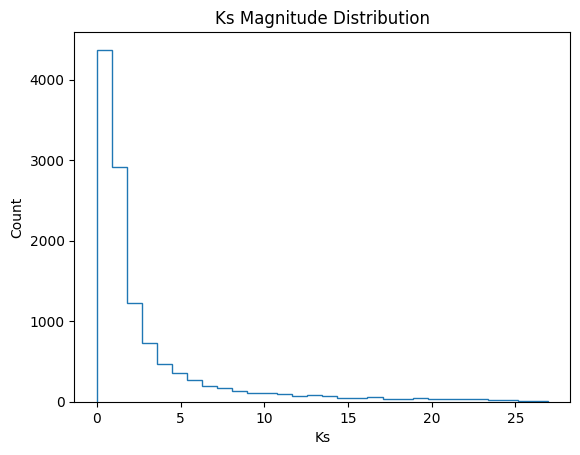

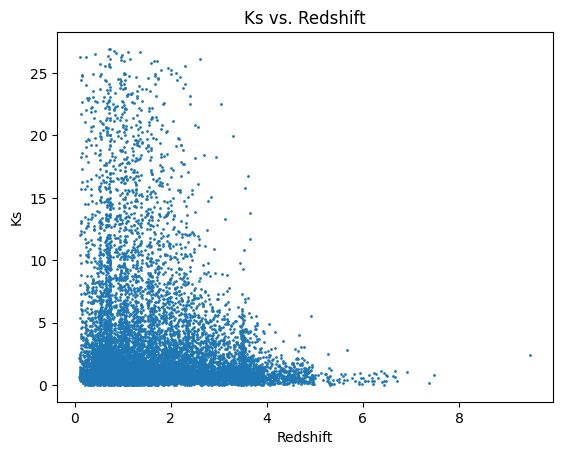

In [218]:
z = df['zpk'] # redshift
mag_app = df['FKs'] # apparent Ks magnitude
mask = (df['FKs'] <= mag_lim)

plt.hist(mag_app[mask], bins=n_lum_bins, histtype='step')
plt.title('Ks Magnitude Distribution')
plt.xlabel('Ks')
plt.ylabel('Count')
plt.show()

plt.scatter(z[mask], mag_app[mask], s=1)
plt.title('Ks vs. Redshift')
plt.xlabel('Redshift')
plt.ylabel('Ks')
plt.show()

### AB Magnitude Distributions

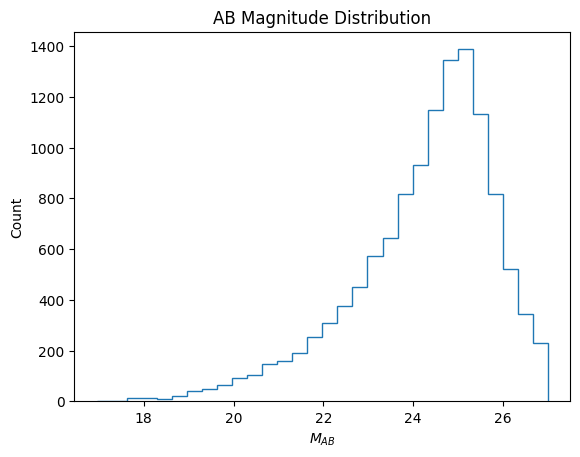

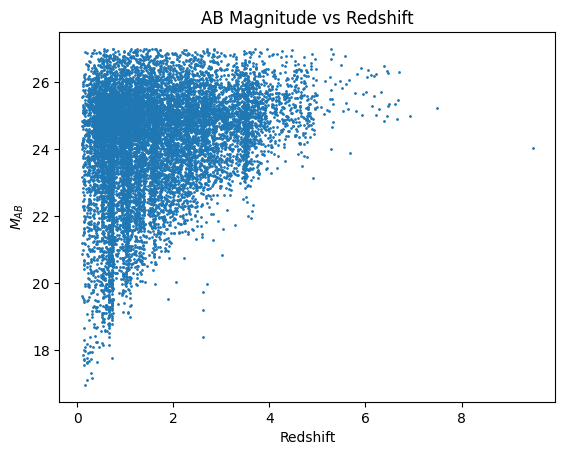

In [219]:
mag_ab = 25 - 2.5*np.log10(mag_app) # apparent magnitude -> AB magnitude
mask = (mag_ab <= mag_lim)

plt.title('AB Magnitude Distribution')
plt.hist(mag_ab[mask], bins=n_lum_bins, histtype='step')
plt.xlabel('$M_{AB}$')
plt.ylabel('Count')
plt.show()

plt.scatter(z[mask], mag_ab[mask], s=1)
plt.title('AB Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('$M_{AB}$')
plt.show()

### Absolute Magnitude Distributions

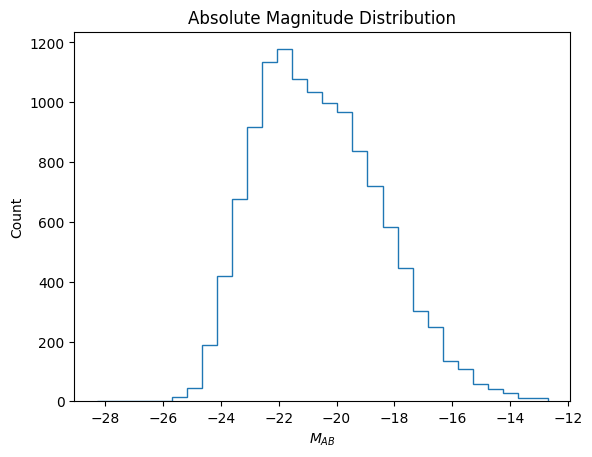

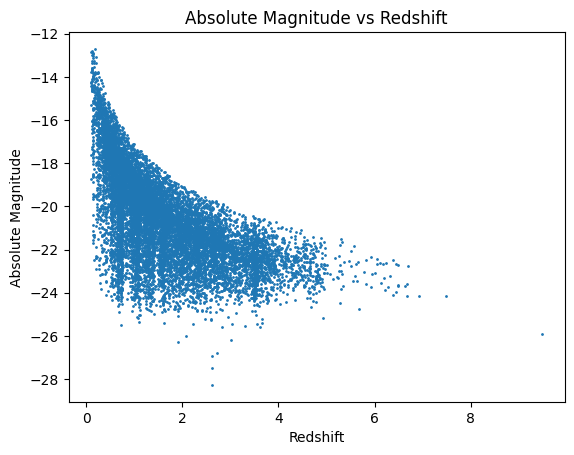

In [220]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
dists = cosmo.luminosity_distance(z) # Mpc
dists *= 10 ** 6 # Mpc -> pc
Mag_abs = mag_ab - 5 * np.log10(dists / 10) # AB magnitude -> absolute magnitude
mask = (mag_ab <= mag_lim) 

plt.title('Absolute Magnitude Distribution')
plt.hist(Mag_abs[mask], bins=n_lum_bins, histtype='step')
plt.xlabel('$M_{AB}$')
plt.ylabel('Count')
plt.show()

plt.scatter(z[mask], Mag_abs[mask], s=1)
plt.title('Absolute Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.show()

### Fitting for Zmax

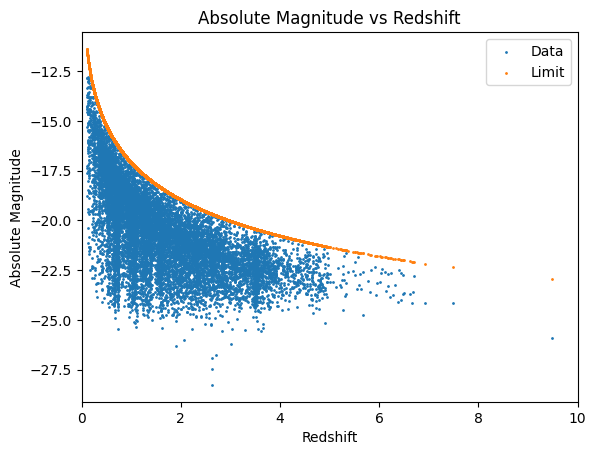

In [221]:
z = z[mask]
Mag_abs = Mag_abs[mask]
dists = dists[mask]

M_lim = mag_lim - 5 * np.log10(dists / 10) # absolute magnitude limit

plt.scatter(z, Mag_abs, s=1, label='Data')
plt.scatter(z, M_lim, s=1, label='Limit')
plt.title('Absolute Magnitude vs Redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.xlim(0, 10)
plt.legend()
plt.show()

### Absolute Magnitude Limit vs Maximum Redshift

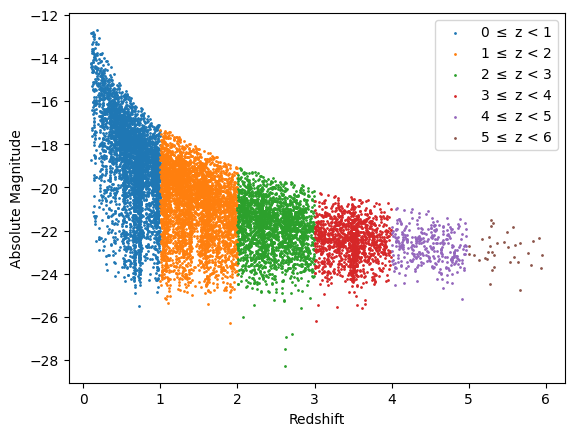

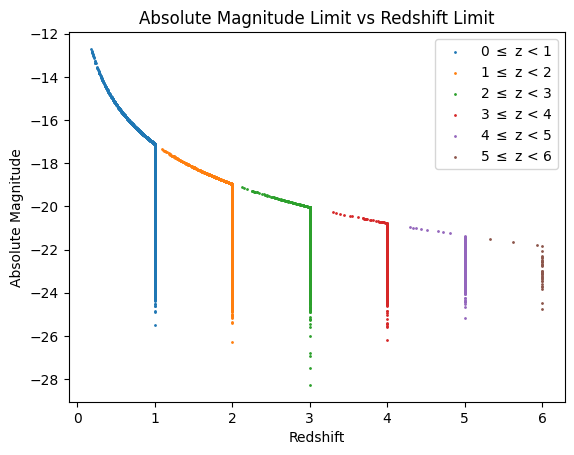

In [222]:
for z_min, z_max in redshift_bins:
    mask = (z >= z_min) & (z < z_max)
    plt.scatter(z[mask], Mag_abs[mask], s=1, label=f'{z_min} $\leq$ z < {z_max}')
    
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.legend()
plt.show()

for z_min, z_max in redshift_bins:
    mask = (z >= z_min) & (z < z_max)
    
    # Find the maximum distance for the redshift bin
    dmax = cosmo.luminosity_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    d = 10 * 10 ** ((mag_lim - Mag_abs[mask]) / 5) # pc
    d /= 10 ** 6 # pc -> Mpc
    
    # Limit the distance to the maximum distance
    d[d > dmax] = dmax
    
    # Find the redshift at the maximum distance
    z_lim = z_at_value(cosmo.luminosity_distance, d.values * u.Mpc)
    
    plt.scatter(z_lim, Mag_abs[mask], s=1, label=f'{z_min} $\leq$ z < {z_max}')
    
plt.title('Absolute Magnitude Limit vs Redshift Limit')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.legend()
plt.show()

### Magnitude Bin Limits vs Maximum Redshift

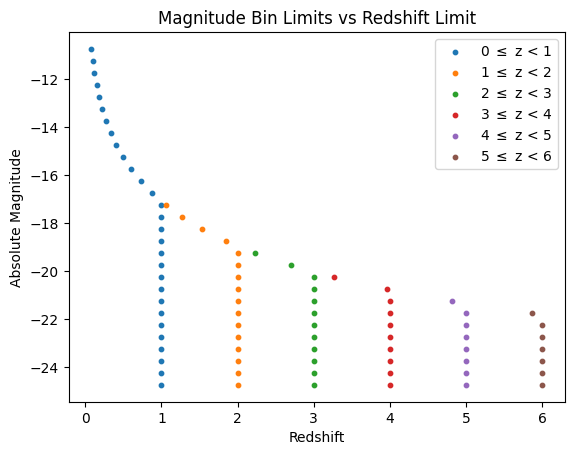

In [223]:
for z_min, z_max in redshift_bins:
    mask = (z >= z_min) & (z < z_max)
    
    Mag_abs_bin = Mag_abs[mask]
    
    # Bin the data by luminosity
    counts, lum_bin_edges = np.histogram(Mag_abs_bin, bins=mag_abs_bins)
    lum_bin_centers = lum_bin_edges[0:-1] + (np.diff(lum_bin_edges)[0] / 2)
    
    # Find the maximum distance for the redshift bin
    dmin = cosmo.luminosity_distance(z_min).value # Mpc
    dmax = cosmo.luminosity_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    d = 10 * 10 ** ((mag_lim - lum_bin_centers) / 5) # pc
    d /= 10 ** 6 # pc -> Mpc
    
    # Distances must be greater than the minimum distance
    d_mask = d >= dmin
    d = d[d_mask]
    lum_bin_centers = lum_bin_centers[d_mask]
        
    # Limit the distance to the maximum distance
    d[d > dmax] = dmax
    
    # Find the redshift at the maximum distance
    z_lim = z_at_value(cosmo.luminosity_distance, d * u.Mpc)
    
    plt.scatter(z_lim, lum_bin_centers, s=10, label=f'{z_min} $\leq$ z < {z_max}')
    
plt.title('Magnitude Bin Limits vs Redshift Limit')
plt.xlabel('Redshift')
plt.ylabel('Absolute Magnitude')
plt.legend()
plt.show()

### Calculate and save binned counts, volumes, magnitudes, & data

In [224]:
all_data = []

for z_min, z_max in redshift_bins:
    
    # Bin the data by redshift
    z_mask = (z >= z_min) & (z < z_max)
    Mag_abs_bin = Mag_abs[z_mask]
    
    # Bin the data by luminosity
    counts, lum_bin_edges = np.histogram(Mag_abs_bin, bins=mag_abs_bins)
    lum_bin_centers = lum_bin_edges[0:-1] + (np.diff(lum_bin_edges)[0] / 2)
    
    # Calculate the minimum and maximum distance of the redshift bin
    dmin = cosmo.comoving_distance(z_min).value
    dmax = cosmo.comoving_distance(z_max).value
    
    # # Find the maximum distance for each source
    dmaxs = 10 * 10 ** ((mag_lim - lum_bin_centers) / 5) # pc
    dmaxs /= 10 ** 6 # pc -> Mpc
    
    # # Distances must be greater than the minimum distance
    d_mask = dmaxs >= dmin
    
    # Apply mask
    dmaxs = dmaxs[d_mask]
    counts = counts[d_mask]
    lum_bin_centers = lum_bin_centers[d_mask]
    
    # If the maximum distance is greater than the maximum redshift bin distance, set it to the maximum redshift bin distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([counts, vol, lum_bin_centers, Mag_abs_bin])

### Counts Histograms

`Mask Threshold` shows the threshold at which magnitude bins will be masked based on the minimum count when the luminosity function is calculated. This is defined in the import and setup cell as `min_count`

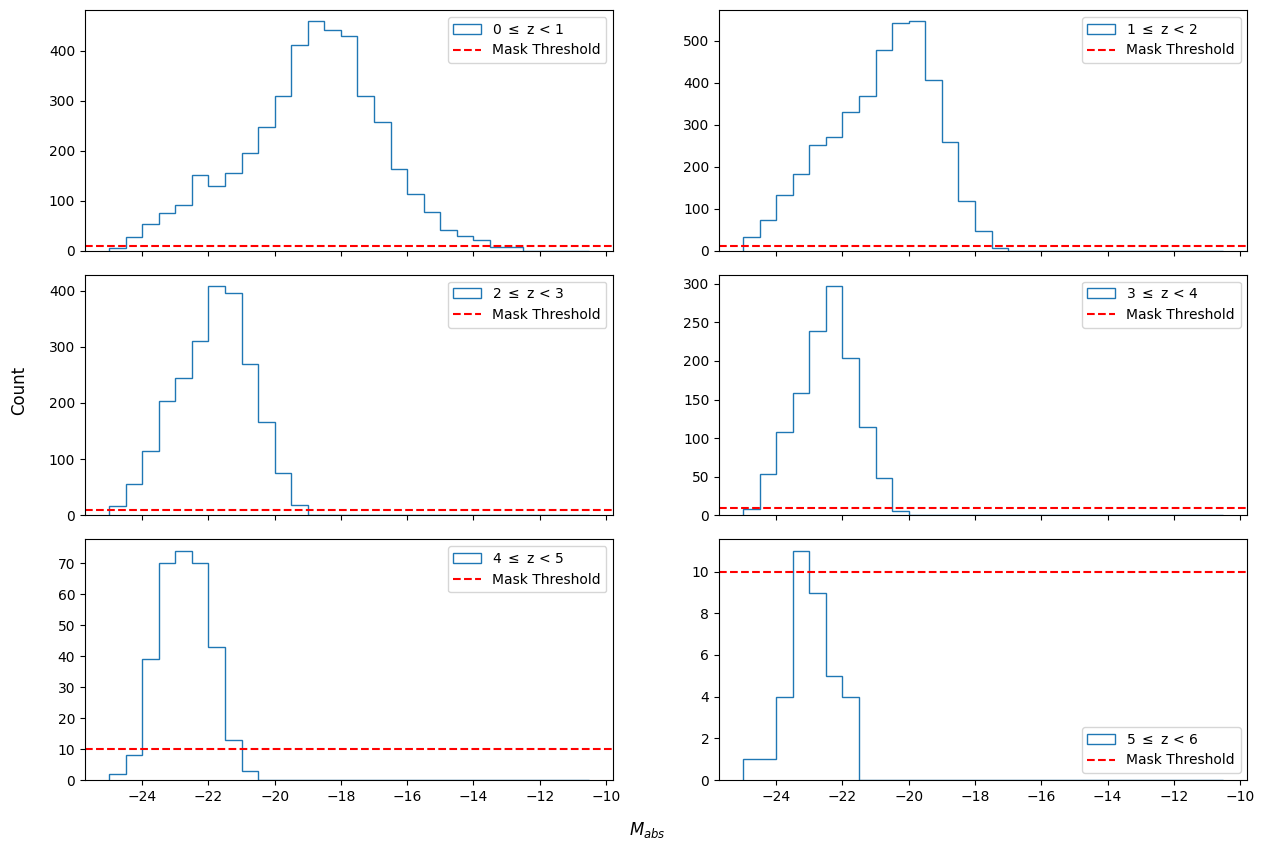

In [225]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    _, _, _, binned_data = d
    
    # Plot the data
    ax.hist(binned_data, bins=mag_abs_bins, histtype='step', label=f'{z_start} $\leq$ z < {z_end}')
    ax.axhline(min_count, color='red', linestyle='--', label='Mask Threshold')
    ax.legend()

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Count', x=0.075)
plt.subplots_adjust(hspace=0.1)
plt.show()

### Volume Plots

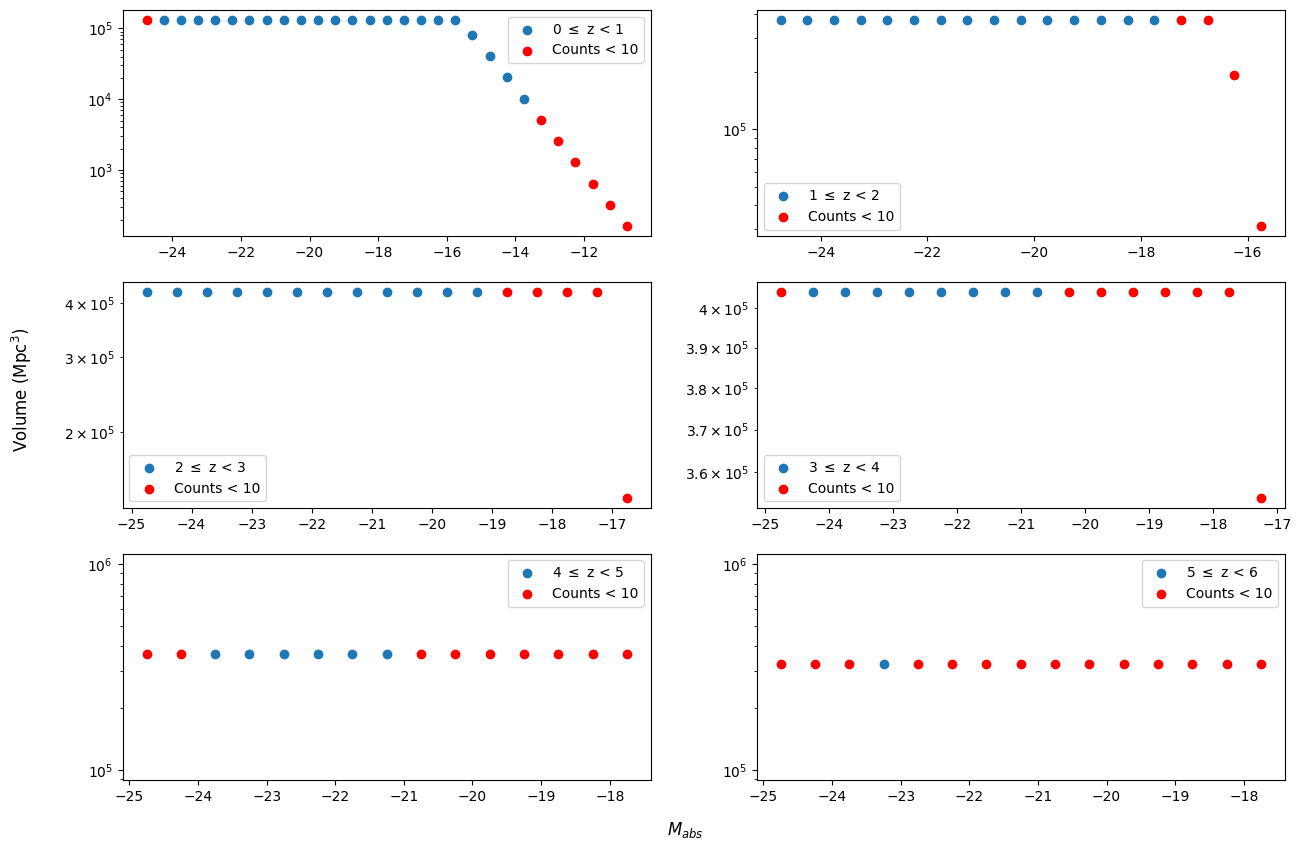

In [226]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    counts, volume, lum_bin_centers, _ = d
    
    # Mask the data
    good_counts = (counts >= min_count)
    bad_counts = (counts < min_count)
    
    # Plot the data
    ax.scatter(lum_bin_centers[good_counts], volume[good_counts], label=f'{z_start} $\leq$ z < {z_end}')
    ax.scatter(lum_bin_centers[bad_counts], volume[bad_counts], color='red', label=f'Counts < {min_count}')
    ax.set_yscale('log')
    ax.legend()
    
fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Volume (Mpc$^3$)', x=0.05)
plt.show()

### Luminosity Function

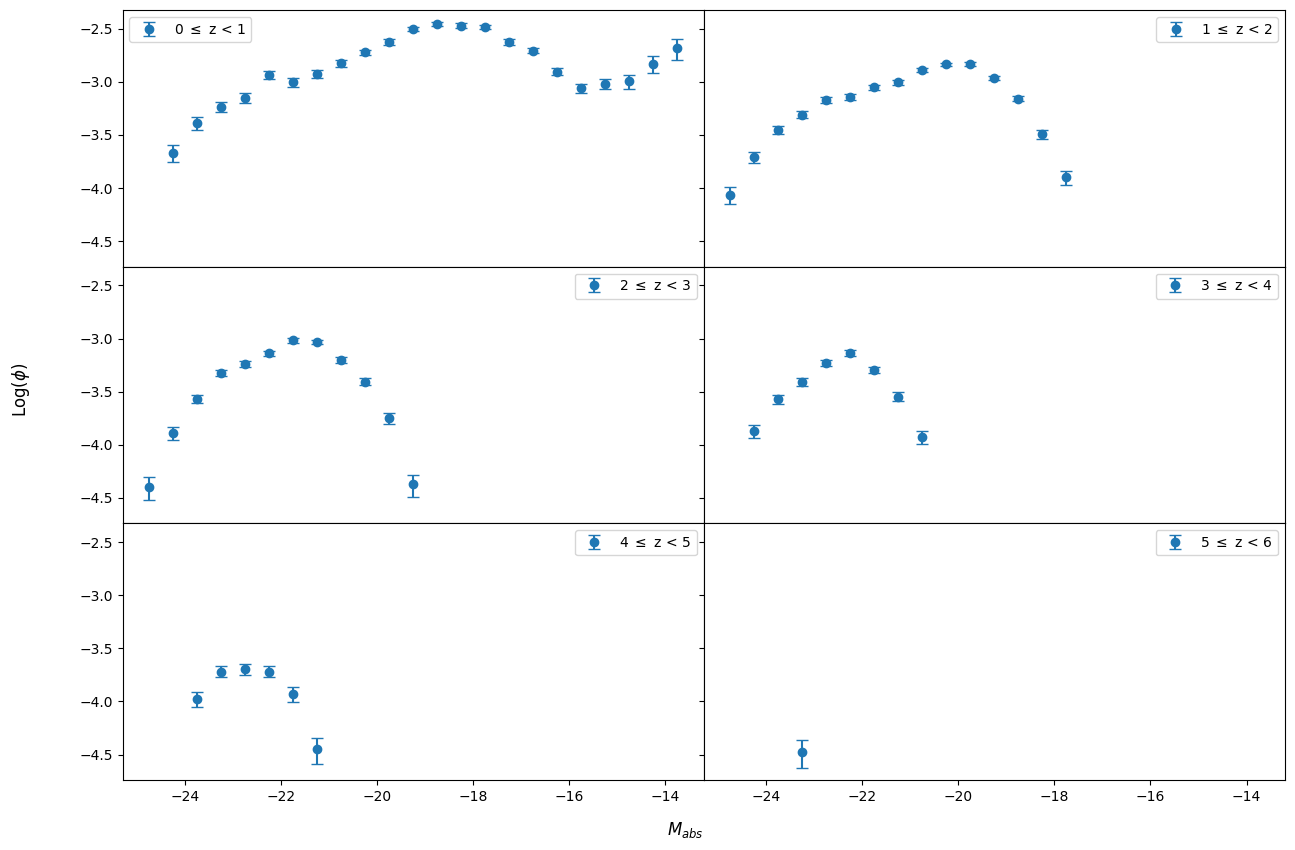

In [227]:
def error(counts, volume):
    upper_counts = counts + np.sqrt(counts)
    lower_counts = counts - np.sqrt(counts)
        
    upper_phi = upper_counts / volume
    lower_phi = lower_counts / volume
    return upper_phi, lower_phi

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    counts, volume, lum_bin_centers, _ = d
    
    # Mask the data
    mask = (counts > min_count) & (volume > 0)
    counts = counts[mask]
    volume = volume[mask]
    lum_bin_centers = lum_bin_centers[mask]
    
    # Calculate the error
    phi = counts / volume
    upp_phi, low_phi = error(counts, volume)
    yerr = [(np.log10(phi) - np.log10(low_phi)), (np.log10(upp_phi) - np.log10(phi))]
    
    # Plot the data
    ax.errorbar(lum_bin_centers, np.log10(phi), yerr=yerr, fmt='o', label=f'{z_start} $\leq$ z < {z_end}', capsize=4)
    ax.legend()

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Schechter Fit

C:\Users\n10480129\AppData\Local\Temp\ipykernel_23540\3279927186.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-10.**(-0.4*(M-M_star)))


0 <= z < 1 Function fit:
M_star = -2.05e+01
phi_star = 5.80e-03
alpha = 7.17e-01


1 <= z < 2 Function fit:
M_star = -2.20e+01
phi_star = 2.75e-03
alpha = 5.86e-01


2 <= z < 3 Function fit:
M_star = -2.21e+01
phi_star = 2.44e-03
alpha = 8.40e-02


3 <= z < 4 Function fit:
M_star = -2.21e+01
phi_star = 1.65e-03
alpha = -4.68e-01


4 <= z < 5 Function fit:
M_star = -2.22e+01
phi_star = 4.61e-04
alpha = -7.95e-01


Failed to fit 5 <= z < 6


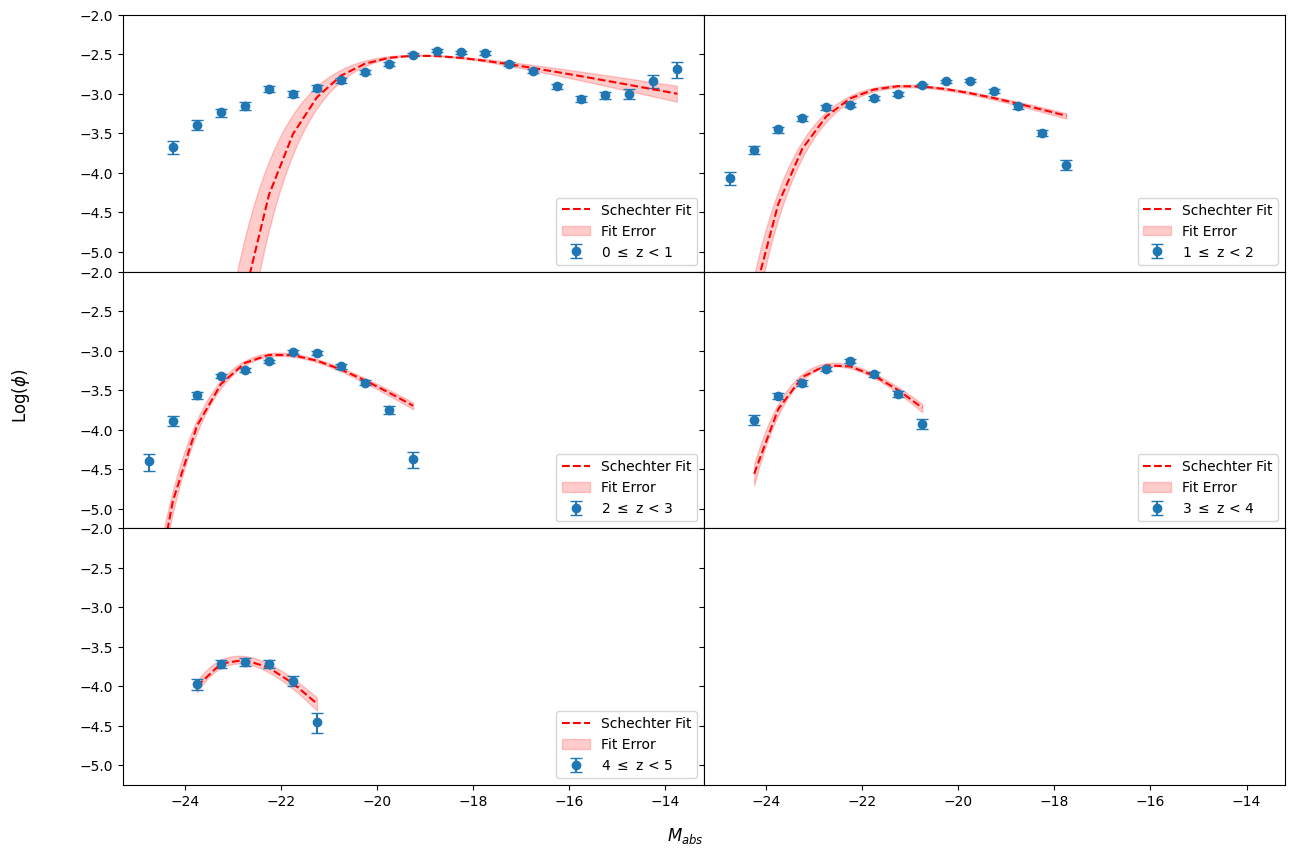

In [228]:
def schechter_magnitude(M, M_star, phi_star, alpha):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-10.**(-0.4*(M-M_star)))

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    counts, volume, lum_bin_centers, _ = d
    
    # Mask the data
    mask = (counts > min_count) & (volume > 0)
    counts = counts[mask]
    volume = volume[mask]
    lum_bin_centers = lum_bin_centers[mask]
    
    # Calculate phis
    phi = counts / volume
    upp_phi, low_phi = error(counts, volume)
    yerr = [(np.log10(phi) - np.log10(low_phi)), (np.log10(upp_phi) - np.log10(phi))]
    
    # Attempt to fit the data
    p0=[lum_bin_centers[0], 0.001, -0.9]
    try:
        params, covars = curve_fit(schechter_magnitude, lum_bin_centers, phi, p0=p0)
        upp_params, _ = curve_fit(schechter_magnitude, lum_bin_centers, upp_phi, p0=p0)
        low_params, _ = curve_fit(schechter_magnitude, lum_bin_centers, low_phi, p0=p0)
    except:
        print(f'Failed to fit {z_start} <= z < {z_end}')
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print('\n')
    
    # Plot the data
    ax.errorbar(lum_bin_centers, np.log10(phi), yerr=yerr, fmt='o', label=f'{z_start} $\leq$ z < {z_end}', capsize=4)
    ax.plot(lum_bin_centers, np.log10(schechter_magnitude(lum_bin_centers, *params)), color='red', label='Schechter Fit', linestyle='--')
    
    long_lum_smooth = np.linspace(lum_bin_centers[0], lum_bin_centers[-1], 100)
    ax.fill_between(long_lum_smooth, 
        np.log10(schechter_magnitude(long_lum_smooth, *low_params)), 
        np.log10(schechter_magnitude(long_lum_smooth, *upp_params)), 
        alpha=0.2, color='red', label='Fit Error')
    
    ax.set_ylim(-5.25, -2)
    ax.legend(loc='lower right')

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Fit

C:\Users\n10480129\AppData\Local\Temp\ipykernel_23540\1644242653.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M - M_star))))**2)


0 <= z < 1 Function fit:
M_star = -1.71e+01
phi_star = 2.61e-03
alpha = 6.31e-01
sigma = 8.25e-01


1 <= z < 2 Function fit:
M_star = -1.55e+01
phi_star = 1.45e-05
alpha = -9.80e-01
sigma = 6.62e-01


2 <= z < 3 Function fit:
M_star = -1.69e+01
phi_star = 2.56e-07
alpha = -2.69e+00
sigma = 4.77e-01


3 <= z < 4 Function fit:
M_star = -1.79e+01
phi_star = 8.05e-09
alpha = -4.62e+00
sigma = 3.70e-01


4 <= z < 5 Function fit:
M_star = -1.76e+01
phi_star = 8.69e-12
alpha = -6.30e+00
sigma = 3.48e-01


Failed to fit 5 <= z < 6


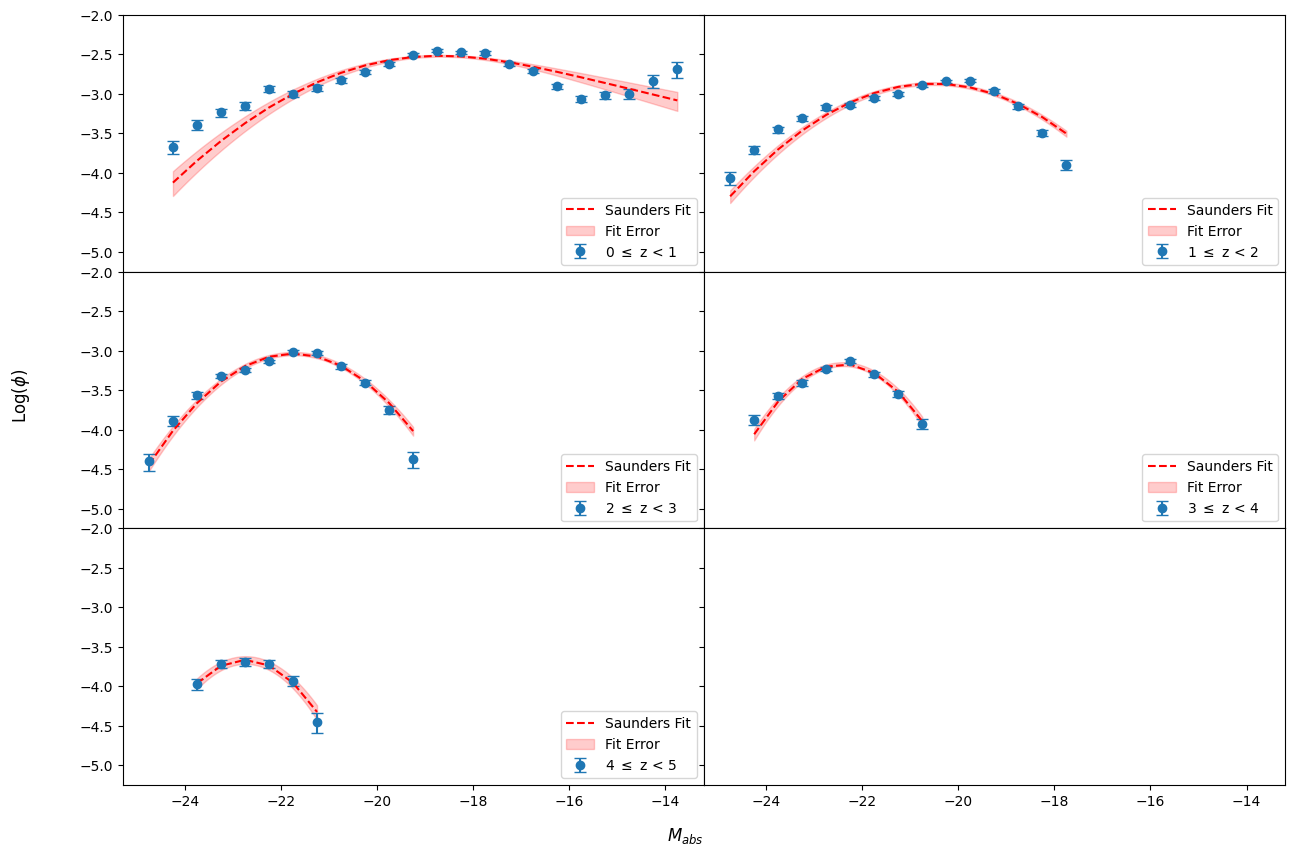

In [229]:
def saunders_magnitude(M, M_star, phi_star, alpha, sigma):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M-M_star)) * np.exp(-1 / (2 * sigma ** 2) * (np.log10(1 + 10 ** (-0.4 * (M - M_star))))**2)

fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey=True)
for ax, d, (z_start, z_end) in zip(axes.flatten(), all_data, redshift_bins):
    counts, volume, lum_bin_centers, _ = d
    
    # Mask the data
    mask = (counts > min_count) & (volume > 0)
    counts = counts[mask]
    volume = volume[mask]
    lum_bin_centers = lum_bin_centers[mask]
    
    # Calculate phis
    phi = counts / volume
    upp_phi, low_phi = error(counts, volume)
    yerr = [(np.log10(phi) - np.log10(low_phi)), (np.log10(upp_phi) - np.log10(phi))]
    
    # Attempt to fit the data
    p0 = [lum_bin_centers[0], 0.001, -0.9, 0.1]
    try:
        params, covars = curve_fit(saunders_magnitude, lum_bin_centers, phi, p0=p0, maxfev=10000)
        upp_params, _ = curve_fit(saunders_magnitude, lum_bin_centers, upp_phi, p0=p0, maxfev=10000)
        low_params, _ = curve_fit(saunders_magnitude, lum_bin_centers, low_phi, p0=p0, maxfev=10000)
    except:
        print(f'Failed to fit {z_start} <= z < {z_end}')
        continue        
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print(f'sigma = {params[3]:.2e}')
    print('\n')
    
    # Plot the data
    ax.errorbar(lum_bin_centers, np.log10(phi), yerr=yerr, fmt='o', label=f'{z_start} $\leq$ z < {z_end}', capsize=4)
    ax.plot(lum_bin_centers, np.log10(saunders_magnitude(lum_bin_centers, *params)), color='red', label='Saunders Fit', linestyle='--')
    
    # Plot the error
    long_lum_smooth = np.linspace(lum_bin_centers[0], lum_bin_centers[-1], 100)
    ax.fill_between(long_lum_smooth, 
        np.log10(saunders_magnitude(long_lum_smooth, *low_params)), 
        np.log10(saunders_magnitude(long_lum_smooth, *upp_params)), 
        alpha=0.2, color='red', label='Fit Error')
    
    ax.set_ylim(-5.25, -2)
    ax.legend(loc='lower right')

fig.supxlabel('$M_{abs}$', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()